# Проект по Методи и софтуер за машинно обучение
Студент: Кристиян Кръчмаров <br>
Фак. номер: 791324005 <br>


## Зареждане на данните

In [1]:
import pandas as pd

path = "../Data/"
data = pd.read_csv(path + "shuffle_email_spam_classification.csv")
data.info()
print("\nNaN in data: {}".format(data.isna().any().any()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB

NaN in data: False


In [2]:
data = data.iloc[:, 1:]  # remove 'Email No' column

X = data.iloc[:, :-1]  # explanatory variables
Y = data.iloc[:, -1]  # result

print(X.shape)
print(Y.shape)

(5172, 3000)
(5172,)


## Helpers
Няколко helper метода <br>

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import clone

def get_metrics(classifier, x_train, y_train, x_test, y_test):
    """Train a classifier and get different metrics"""

    classifier = clone(classifier)  # get unfitted classifier
    classifier.fit(x_train, y_train)  # train

    predicted = classifier.predict(x_test)  # get prediction
    probabilities = classifier.predict_proba(x_test)  # get probabilities of each class
    probabilities = probabilities[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, probabilities)  # ROC curve
    auc = roc_auc_score(y_test, probabilities)  # AUC score

    conf_matrix = confusion_matrix(y_test, predicted)  # confusion matrix

    accuracy = classification_report(y_test, predicted, output_dict=True)['accuracy']  # accuracy
    cl_report = classification_report(y_test, predicted, output_dict=False)  # classification report

    return {
        "ACC": accuracy,
        "AUC": auc,
        "TPR": tpr,
        "FPR": fpr,
        "Threshold": threshold,
        "ConfusionMatrix": conf_matrix,
        "ClassificationReport": cl_report,
    }


In [4]:
import matplotlib.pyplot as plt

def get_metrics_train_and_test(classifier, x_train, y_train, x_test, y_test, plot_roc_curve=False):
    """
    Get metrics for a classifier when training and test data are the same and also train and test data are different.
    Plot the ROC curve.
    Return the metrics for each training scenario
    """
    train_train = get_metrics(classifier, x_train, y_train, x_train, y_train)
    train_test = get_metrics(classifier, x_train, y_train, x_test, y_test)

    # Plot setup
    if plot_roc_curve:
        fg, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].set_xlim([-0.05, 1.05])
        axes[0].set_ylim([-0.05, 1.05])
        axes[0].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[0].set_title("ROC (Test set)")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        axes[1].set_xlim([-0.05, 1.05])
        axes[1].set_ylim([-0.05, 1.05])
        axes[1].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[1].set_title("ROC (Training set)")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")

        axes[0].plot(train_test["FPR"], train_test["TPR"], marker="", color="green", alpha=0.6)
        axes[1].plot(train_train["FPR"], train_train["TPR"], marker="", color="red", alpha=0.6)

        plt.show()

    return {
        "train-train": train_train,
        "train-test": train_test,
    }

За метода `k_fold_cross_validation` използваме `StratifiedKFold` за да се запази разделението

In [5]:
from sklearn.model_selection import KFold

def k_fold_cross_validation(classifier, X: pd.DataFrame, Y: pd.DataFrame, splits=10, plot_roc_curve=False):
    """
    Perform k-fold cross validation for classifier.
    Plot the ROC curve for each fold.
    Return performance metrics for each fold.
    """

    kf = KFold(n_splits=splits, shuffle=True, random_state=42)

    df_columns = ["Fold", "ACC Test", "ACC Training", "ACC ratio", "AUC Test", "AUC Training", "AUC ratio", "CONF_MTX"]
    performance_df = pd.DataFrame(columns=df_columns)

    # plot setup
    if plot_roc_curve:
        fg, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].set_xlim([-0.05, 1.05])
        axes[0].set_ylim([-0.05, 1.05])
        axes[0].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[0].title.set_text("k-Fold ROC (Test set)")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        axes[1].set_xlim([-0.05, 1.05])
        axes[1].set_ylim([-0.05, 1.05])
        axes[1].plot([0, 1], [0, 1], linestyle="-", color='k')
        axes[1].title.set_text("k-Fold ROC (Training set)")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")

    i = 0
    #k-fold
    for trainIndex, testIndex in kf.split(X, Y):
        print(f"Processing fold {i + 1}...")
        X_train, X_test = X.iloc[trainIndex], X.iloc[testIndex]
        Y_train, Y_test = Y.iloc[trainIndex], Y.iloc[testIndex]

        metrics_train_train = get_metrics(classifier, X_train, Y_train, X_train, Y_train)
        metrics_train_test = get_metrics(classifier, X_train, Y_train, X_test, Y_test)

        if plot_roc_curve:
            axes[0].plot(metrics_train_test["FPR"], metrics_train_test["TPR"], marker="", color="blue", alpha=0.6)
            axes[1].plot(metrics_train_train["FPR"], metrics_train_train["TPR"], marker="", color="orange", alpha=0.6)

        temp = {'Fold': i,
                'ACC Test': metrics_train_test["ACC"],
                'ACC Training': metrics_train_train["ACC"],
                'ACC ratio': metrics_train_test["ACC"] / metrics_train_train["ACC"],
                'AUC Test': metrics_train_test["AUC"],
                'AUC Training': metrics_train_train["AUC"],
                'AUC ratio': metrics_train_test["AUC"] / metrics_train_train["AUC"],
                'CONF_MTX': metrics_train_test["ConfusionMatrix"]}

        temp_df = pd.DataFrame([temp])
        performance_df = pd.concat([performance_df, temp_df], ignore_index=True)
        i = i + 1

    if plot_roc_curve:
        plt.show()

    return performance_df

In [6]:
def print_metrics(metrics_train_and_test):
    """Print metrics for differently trained classifier"""
    train_train = metrics_train_and_test.get('train-train', 'not-found')
    train_test = metrics_train_and_test.get('train-test', 'not-found')

    print("Train-Train ACC: {}".format(train_train.get('ACC', 'not-found')))
    print("Train-Test ACC: {}".format(train_test.get('ACC', 'not-found')))
    print("\n")
    print("Train-Train AUC: {}".format(train_train.get('AUC', 'not-found')))
    print("Train-Test AUC: {}".format(train_test.get('AUC', 'not-found')))
    print("\n")
    print("Train-Train Confusion Matrix: \n {}".format(train_train.get('ConfusionMatrix', 'not-found')))
    print("\n")
    print("Train-Test Confusion Matrix: \n {}".format(train_test.get('ConfusionMatrix', 'not-found')))
    print("\n")
    # print("Train-Train Classification report: \n {}".format(train_train.get('ClassificationReport', 'not-found')))
    # print("\n")
    # print("Train-Test Classification report: \n {}".format(train_test.get('ClassificationReport', 'not-found')))


In [7]:
def plot_history_nn(nn):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(nn.history['accuracy'], color='blue')
    ax[0].plot(nn.history['val_accuracy'], color='green')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Train', 'Validate'])
    ax[0].axis(ymin=0.5, ymax=1.1)
    ax[0].margins(0.03)

    ax[1].plot(nn.history['loss'])
    ax[1].plot(nn.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Validate'])
    ax[1].margins(0.03)

    plt.show()

## 1. Logistic regression
Първо ще обучим един `LogisticRegression` без preprocessing, за да видим как се справя

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


C:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


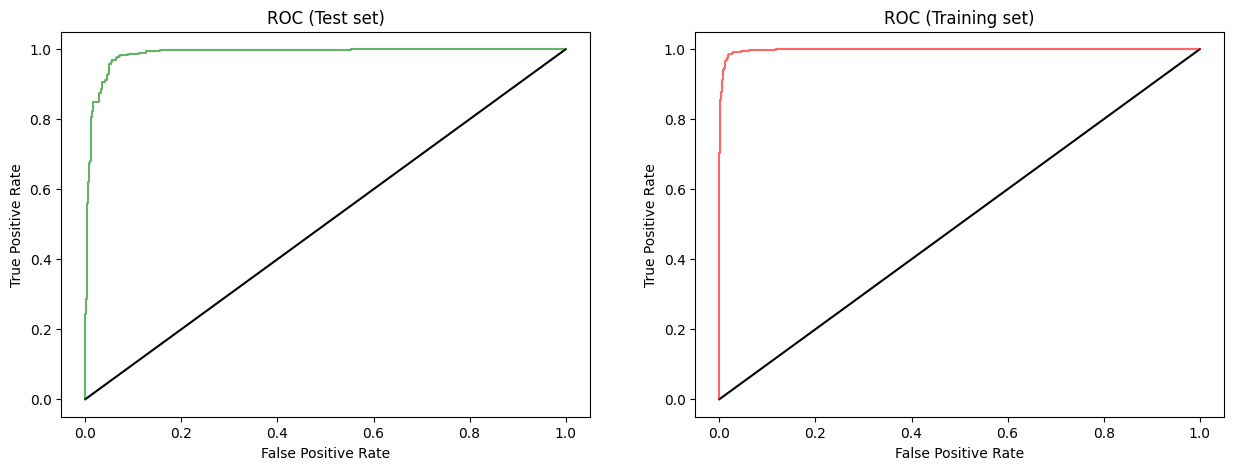

In [10]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()

lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test, plot_roc_curve=True)

Проверяваме модела чрез k_fold cross валидация

In [11]:
# import warnings  # to not log the same warning on every iteration
#
# warnings.filterwarnings('ignore')
# lr_k_fold = k_fold_cross_validation(logistic_regression, X, Y, plot_roc_curve=True)
# warnings.filterwarnings('default')
#
# lr_k_fold.head(10)

In [12]:
print_metrics(lr_metrics_train_and_test)

Train-Train ACC: 0.9813874788494078
Train-Test ACC: 0.9420289855072463


Train-Train AUC: 0.9980434626317909
Train-Test AUC: 0.9867829670817714


Train-Train Confusion Matrix: 
 [[2914   34]
 [  43 1146]]


Train-Test Confusion Matrix: 
 [[703  21]
 [ 39 272]]




Сега ще приложим някакъв вид preprocessing, за да видим дали ще има промяна <br>
В случая съм използвал `MinMaxScaler` чрез който всичките ни данни ще са в диапазона $[0,1]$.

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


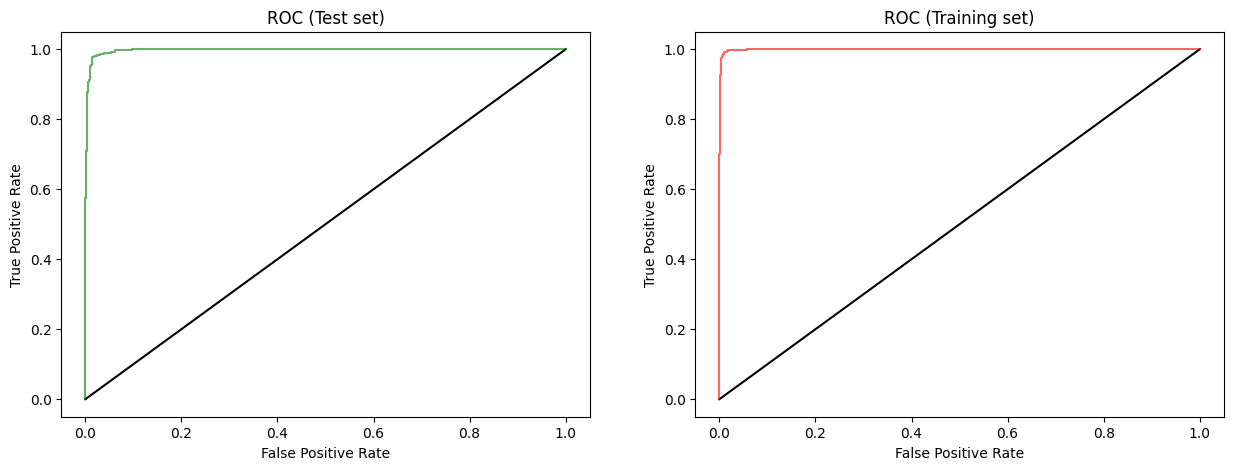

In [14]:
logistic_regression = LogisticRegression()
lr_metrics_train_and_test = get_metrics_train_and_test(logistic_regression, X_train, Y_train, X_test, Y_test, plot_roc_curve=True)

In [15]:
# lr_k_fold = k_fold_cross_validation(logistic_regression, X_scaled, Y, plot_roc_curve=True)
# lr_k_fold.head(10)

In [16]:
print_metrics(lr_metrics_train_and_test)

Train-Train ACC: 0.9886391104665216
Train-Test ACC: 0.9835748792270531


Train-Train AUC: 0.9992679816001441
Train-Test AUC: 0.9973119262699778


Train-Train Confusion Matrix: 
 [[2922   11]
 [  36 1168]]


Train-Test Confusion Matrix: 
 [[729  10]
 [  7 289]]




Точността $ACC$ се повиши от Train-Test $ACC \approx 0.94$ на Train-Test $ACC \approx 0.98$, което е подобрение. <br>
Не се наблюдава underfitting или overfitting

## 2. Random forest
Ще обучим един `RandomForestClassifier` без preprocessing на данните за да видим как ще се справи

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


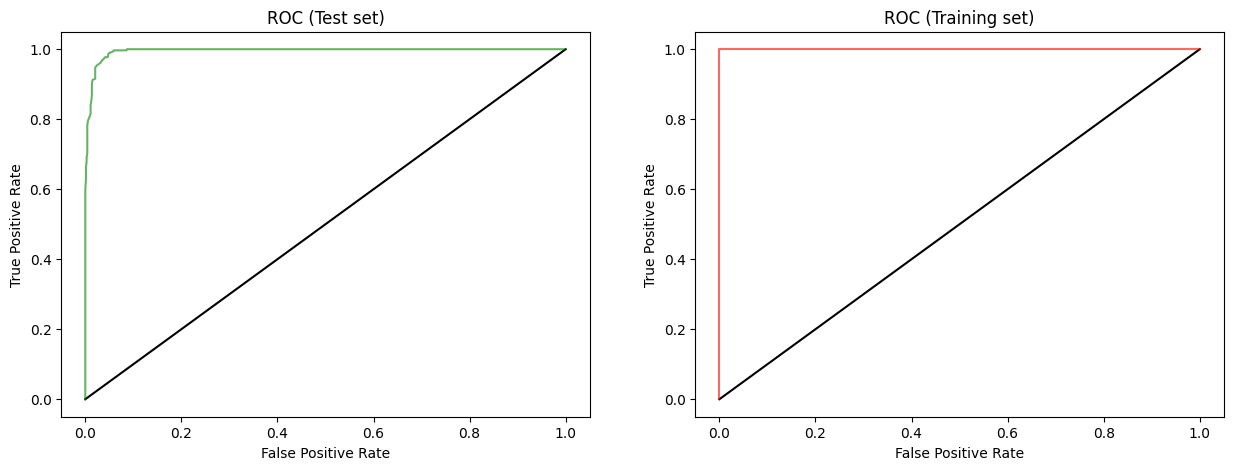

In [18]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

rf_metrics_train_and_test = get_metrics_train_and_test(random_forest, X_train, Y_train, X_test, Y_test, plot_roc_curve=True)

In [19]:
# rf_k_fold = k_fold_cross_validation(random_forest, X, Y, plot_roc_curve=True)
# rf_k_fold.head(10)

In [20]:
print_metrics(rf_metrics_train_and_test)

Train-Train ACC: 1.0
Train-Test ACC: 0.9681159420289855


Train-Train AUC: 1.0
Train-Test AUC: 0.9951164722485218


Train-Train Confusion Matrix: 
 [[2945    0]
 [   0 1192]]


Train-Test Confusion Matrix: 
 [[712  15]
 [ 18 290]]




Модела се справя добре с данните на които е обучен, както и тестовите данни. Не е необходим preprocessing на даннните. <br>
Няма наличие на underfitting или overfitting.

## 3. Neural network
Ще се наложи използването на `MinMaxScaller`

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4137, 3000) (4137,)
(1035, 3000) (1035,)


In [10]:
from keras import models, layers

NUMBER_INPUTS = X_train.shape[1]

network_layers = [layers.Input(shape=(NUMBER_INPUTS,)),
                  layers.Dense(128, activation='relu'),
                  layers.Dense(64, activation='relu'),
                  layers.Dense(32, activation='relu'),
                  layers.Dense(16, activation='relu'),
                  layers.Dense(1, activation='sigmoid')]

neural_network = models.Sequential(network_layers)

neural_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

neural_network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,009 (1.51 MB)

 Trainable params: 395,009 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = neural_network.fit(X_train, Y_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7507 - loss: 0.5505 - val_accuracy: 0.9444 - val_loss: 0.1719
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9762 - loss: 0.1087 - val_accuracy: 0.9783 - val_loss: 0.0961
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9931 - loss: 0.0355 - val_accuracy: 0.9734 - val_loss: 0.0842
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9949 - loss: 0.0209 - val_accuracy: 0.9783 - val_loss: 0.1160
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9969 - loss: 0.0121 - val_accuracy: 0.9807 - val_loss: 0.0886
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0072 - val_accuracy: 0.9795 - val_loss: 0.1005
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9991 - loss: 0.0057 - val_accuracy: 0.9819 - val_loss: 0.1081
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 0.9783 - val_loss:

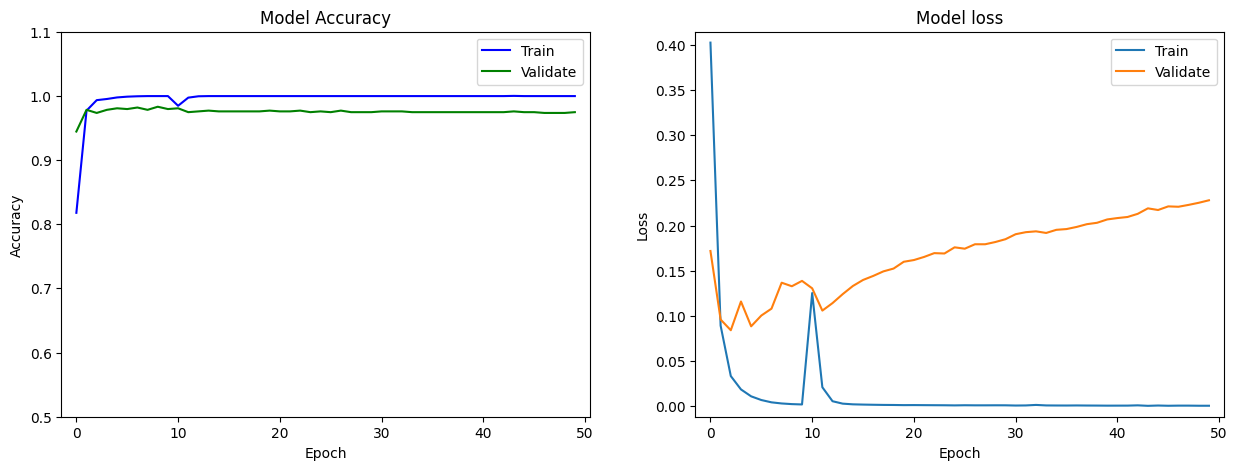

In [19]:
plot_history_nn(history)

Невронната мрежа започва да overfitва след около 10тата епоха на обучение, защото loss функцията за валидационнитте данни започва да расте

In [ ]:
network_layers_2 = [layers.Input(shape=(NUMBER_INPUTS,)),
                  layers.Dense(128, activation='relu'),
                  layers.Dense(64, activation='relu'),
                  layers.Dense(32, activation='relu'),
                  layers.Dense(16, activation='relu'),
                  layers.Dense(1, activation='sigmoid')]
